<a href="https://colab.research.google.com/github/cc4351/teamtracking/blob/Chen/0613_Chen_Summary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Summary**

This is a summary note on the progress I've made on the particle side, and will include the followings:
- part1: the modifications I've made on Matlab scripts [DONE]
- part2: a commented python script to organze particle- and track- level data into a defaultdict [DONE]
- part3: data analysis on pValue
- part4: my attempts to incorporate pValues with track-level features

In [0]:
# import packages 
# --> run this cell if you plan to run any parts other than part1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import statistics
import math
from time import time
import os
from collections import defaultdict
import pickle

# Part 1 Matlab Modifications

**Part 1 Matlab Modifications**
- for the complete scripts that have been modified: https://github.com/cc4351/teamtracking/tree/Chen/Matlab%20Modification
- in detectSubResFeatures2D_V2.m
```
% line 238 --> added a field 'pValue'
    clustersMMF = repmat(struct('position',[],'amplitude',[],'bgAmp',[],...
        'numDegFree',[],'residuals',[],'sigma',[], 'pValue', []),numClusters,1)
% line 433, 514 --> added the pValue into clustersMMF
    clustersMMF(i).pValue = pValue;
% line 756-762 --> save the value in keepCluster
    if pValue < alphaF
        keepCluster(iCluster) = 0;
    else
        keepCluster(iCluster) = pValue;
    end
% line 780 --> save pValue in detectedFeatures
    detectedFeatures.pValue = vertcat(clustersMMF.pValue); 
```
- in detectSubResFeatures2D_StandAlone.m
```
% line 499-500 --> added a field to cands
    movieInfo = repmat(struct('xCoord',[],'yCoord',[],'amp',[],'sigma',[], 'pValue', []),numImagesRaw,1);
```


# Part 2 Python Script to Reorganize the Data Structure

In [0]:
# load data
# ref: https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb#scrollTo=WzIRIt9d2huC
# note that all the data could be found at https://github.com/cc4351/teamtracking/tree/Chen/data

# REMEMBER TO MOUNT YOUR GOOGLE DRIVE AND CHANGE FILE PATHS BEFORE RUNNING THIS CELL

# load tracksFinal.mat
tracksFinal = loadmat('/content/drive/My Drive/Colab Notebooks/Molecule/tracksFinal.mat')['tracksFinal'] #<=replace the path
coordAmp = tracksFinal['tracksCoordAmpCG']
tracksIdx = tracksFinal['tracksFeatIndxCG']
seqOfEvents = tracksFinal['seqOfEvents']
# trackStartFrameIndex
myTrackStart = loadmat('/content/drive/My Drive/Colab Notebooks/Molecule/trackStart.mat')['trackStart'] #<=replace the path
# movieInfo with pValues
movieInfo = loadmat('/content/drive/My Drive/Colab Notebooks/Molecule/new_movieInfo.mat')['movieInfo'] #<=replace the path
xCoord = movieInfo['xCoord']
yCoord = movieInfo['yCoord']
ampCoord = movieInfo['amp']
pValues = movieInfo['pValue']

In [0]:
# for frame_particles: 
# the key is the global frame index, 
# the value is the x, y, amp, and pValue of each particles detected at each frame

numFrame = len(xCoord)
frame_particles = defaultdict(list)
for i in range(numFrame):
    xCo = xCoord[i][0][:, 0]
    yCo = yCoord[i][0][:, 0]
    amps = ampCoord[i][0][:, 0]
    pVal = pValues[i][0]
    numSpot = len(xCo)
    li = np.column_stack((xCo, yCo, amps, pVal))
    frame_particles[i] = li

In [0]:
# save data into defaultdict tracks

# track object: ['length', 'particles', 'track_start', 'track_end']
# particle object: ['x', 'y', 'amp', 'x-std', 'y-std', 'amp-std', 'frame', 'frame_index', 'pValue']
# particle[trackId]-->dictionary of dictionaries
# note that everything starts from 0 in Python, so the frameId, trackId, and the particleId should be (NumInMatlab-1) 

particles = defaultdict(dict)
tracks = defaultdict(dict)

"""
For every frame, the matrix stores
the particle’s x-coordinate, y-coordinate, z-coordinate (0 if 2D),amplitude, x-coordinate standard deviation, ycoordinate
standard deviation, z-coordinate standard deviation (0 if 2D) and amplitude standard deviation.
"""
for i in enumerate(coordAmp):
    content = i[1][0][0]
    tracks[i[0]]['length'] = len(content)//8
    tmp = list()
    per = dict()
    for j in enumerate(content):
        idx = j[0]
        item = j[1]
        if idx%8 == 0:
            if per!={}:
                tmp.append(per)
            per = dict()
            per['x'] = item
        elif idx%8 == 1:
            per['y'] = item
        elif idx%8 == 3:
            per['amp'] = item
        elif idx%8 == 4:
            per['x-std'] = item
        elif idx%8 == 5:
            per['y-std'] = item
        elif idx%8 == 7:
            per['amp-std'] = item
    tmp.append(per)
    tracks[i[0]]['particles'] = tmp

In [0]:
# step-1 find the global frame index for each particle
for i in enumerate(myTrackStart):
    idx = i[0]
    sequence = i[1][0]
    tracks[idx]['track_start'] = sequence
    tracks[idx]['track_end'] = sequence + tracks[idx]['length']-1
    tr = tracks[idx]
    for j in enumerate(tr['particles']):
        count = j[0]
        j[1]['frame'] = sequence+count

In [0]:
# step-2 find the particle index local to each frame
# tracksIdx = tracksFinal['tracksFeatIndxCG']
for i in enumerate(tracksIdx):
    idx = i[0]
    sequence = i[1][0][0]
    tr = tracks[idx]
    for j in enumerate(tr['particles']):
        count = j[0]
        j[1]['frame_index'] = sequence[count]

In [0]:
# step-3 find the corresponding p-values
for k, v in tracks.items():
    for j in v['particles']:
        frame = j['frame']-1
        idx = j['frame_index']-1
        val = pValues[frame][0][idx][0]
        j['pValue'] = val

In [19]:
tracks[0]['particles'][-1]

{'amp': 0.0005410485793569974,
 'amp-std': 5.479991328460485e-05,
 'frame': 1354,
 'frame_index': 8,
 'pValue': 2.7620687702567537e-06,
 'x': 68.10772549184743,
 'x-std': 0.15274471488255942,
 'y': 125.76983235393375,
 'y-std': 0.15273932675794977}

In [0]:
# save the structure into a designated folder
# ref: https://www.saltycrane.com/blog/2008/01/saving-python-dict-to-file-using-pickle/
while tracks[len(tracks)-1] == {}:
    del tracks[len(tracks)-1]
output = open('/content/drive/My Drive/Colab Notebooks/Molecule/tracks', 'wb')
pickle.dump(tracks, output)
output.close()

# Part 3 Data Analysis on pValue

In [0]:
# if part2 is not run beforehand and the tracks data is available in google drive
# run this cell
pkl_file = open('/content/drive/My Drive/Colab Notebooks/Molecule/tracks', 'rb')
tracks = pickle.load(pkl_file)
pkl_file.close()

In [0]:
pAvgs = [] # for mean of pValue
pStds = [] # for std of pValue
pLengths = [] # for trackLength

for item in tracks.values():
    pLengths.append(item['length'])
    pList = []
    for pt in item['particles']:
        pList.append(pt['pValue'])
    pAvgs.append(statistics.mean(pList))
    pStds.append(statistics.pstdev(pList))

Text(0, 0.5, 'trackLength')

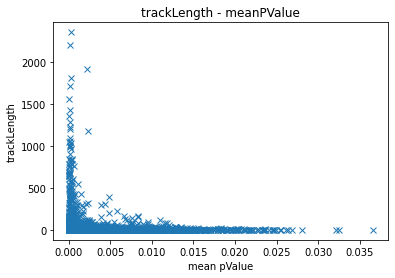

In [46]:
plt.plot(pAvgs, pLengths, 'x')  
plt.title('trackLength - meanPValue')
plt.xlabel('mean pValue')
plt.ylabel('trackLength')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


Text(0, 0.5, 'log of trackLength')

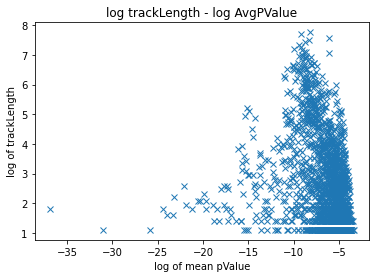

In [47]:
plt.plot(np.log(pAvgs), np.log(pLengths), 'x')  
plt.title('log trackLength - log AvgPValue')
plt.xlabel('log of mean pValue')
plt.ylabel('log of trackLength')

Text(0, 0.5, 'trackLength')

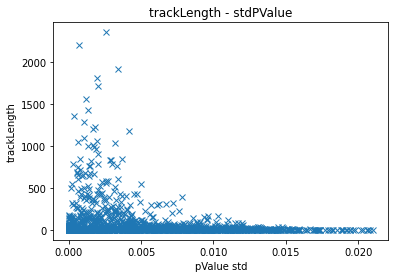

In [48]:
plt.plot(pStds, pLengths, 'x')  
plt.title('trackLength - stdPValue')
plt.xlabel('pValue std')
plt.ylabel('trackLength')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


Text(0, 0.5, 'log of trackLength')

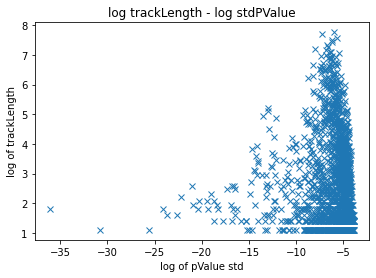

In [49]:
plt.plot(np.log(pStds), np.log(pLengths), 'x')  
plt.title('log trackLength - log stdPValue')
plt.xlabel('log of pValue std')
plt.ylabel('log of trackLength')

Text(0.5, 1.0, 'track 1 - pValue variation')

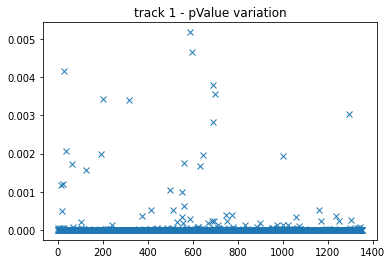

In [50]:
# longest single track: the change of pValue over a track
trackId = 0
item = tracks[trackId]
pList = []
for pt in item['particles']:
    pList.append([pt['frame'], pt['pValue']])
pList = np.asarray(pList)
plt.plot(pList[:, 0], pList[:, 1], 'x')
plt.title('track 1 - pValue variation')

Text(0.5, 1.0, 'last track - pValue variation')

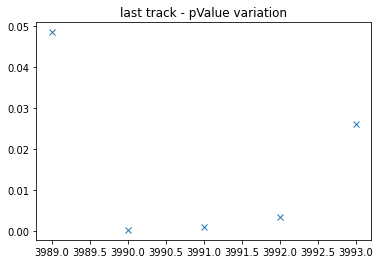

In [53]:
# one of the shortest single track: the change of pValue over a track
trackId = len(tracks)-1
item = tracks[trackId]
pList = []
for pt in item['particles']:
    pList.append([pt['frame'], pt['pValue']])
pList = np.asarray(pList)
plt.plot(pList[:, 0], pList[:, 1], 'x')
plt.title('last track - pValue variation')

# Part 4 T-SNE and DBSCAN with pValue Incorporated